In [1]:
!gdown --id 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 33.0MB/s]


In [2]:
import pandas as pd

df = pd.read_csv('Auto_MPG_data.csv')
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Europe        392 non-null    int64  
 8   Japan         392 non-null    int64  
 9   USA           392 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 30.8 KB


In [5]:
df.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,0.173469,0.201531,0.625000
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.379136,0.401656,0.484742
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,0.000000,0.000000,0.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [58]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
  torch.cuda.manual_seed(random_state)

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [60]:
X = df.drop('MPG', axis=1).values
y = df['MPG'].values

In [61]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, shuffle=is_shuffle, random_state=random_state
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, shuffle=is_shuffle, random_state=random_state
)

In [62]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train, X_val, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_val, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_val, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [63]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [64]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [65]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.ln = nn.Sequential(
        nn.Linear(input_dims, hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims, hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims, output_dims)
    )

  def forward(self, x):
    return self.ln(x).squeeze(1)


In [66]:
input_dims = X_train.shape[1]
hidden_dims = 64
output_dims = 1

model = MLP(input_dims, hidden_dims, output_dims).to(device)

In [67]:
from sklearn.metrics import r2_score
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
  model.train()
  train_loss = 0.0
  train_predict = []
  val_predict = []
  train_target = []
  val_target = []
  val_loss = 0.0
  for i, (Xi, yi) in enumerate(train_loader):
    Xi, yi = Xi.to(device), yi.to(device)
    optimizer.zero_grad()
    output = model(Xi)
    loss = criterion(output, yi)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_predict.append(output.cpu().detach().numpy())
    train_target.append(yi.cpu().detach().numpy())
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_r2.append(r2_score(np.concatenate(train_target), np.concatenate(train_predict)))
  model.eval()
  with torch.no_grad():
    for i, (Xi, yi) in enumerate(val_loader):
      Xi, yi = Xi.to(device), yi.to(device)
      output = model(Xi)
      loss = criterion(output, yi)
      val_loss += loss.item()
      val_predict.append(output.cpu().detach().numpy())
      val_target.append(yi.cpu().detach().numpy())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r2_score(np.concatenate(val_target), np.concatenate(val_predict)))
  if epoch % 10 == 0:
    print(f"Epochs: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epochs: 1/100, Train Loss: 282.7695, Val Loss: 88.6709
Epochs: 11/100, Train Loss: 27.2564, Val Loss: 19.4842
Epochs: 21/100, Train Loss: 8.3896, Val Loss: 4.5509
Epochs: 31/100, Train Loss: 7.9876, Val Loss: 5.9788
Epochs: 41/100, Train Loss: 5.9545, Val Loss: 21.4820
Epochs: 51/100, Train Loss: 8.0511, Val Loss: 7.5701
Epochs: 61/100, Train Loss: 5.7668, Val Loss: 9.3701
Epochs: 71/100, Train Loss: 5.1850, Val Loss: 4.7271
Epochs: 81/100, Train Loss: 11.6171, Val Loss: 6.6412
Epochs: 91/100, Train Loss: 5.4218, Val Loss: 8.5626


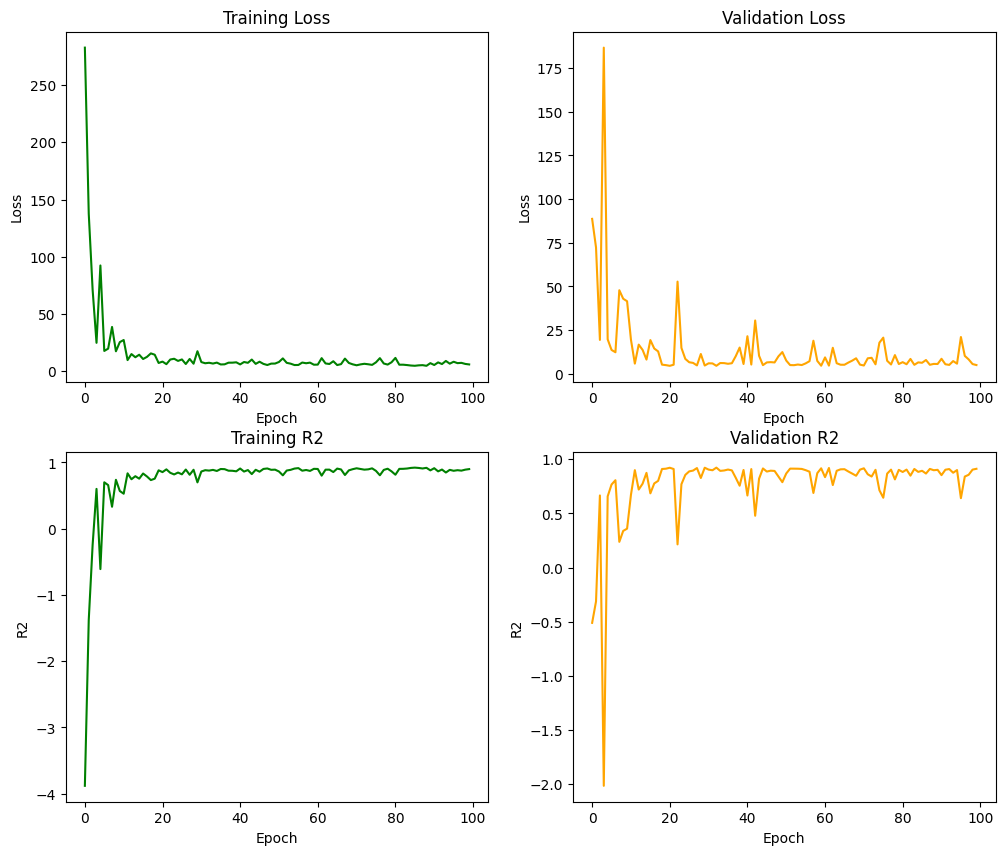

In [68]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_r2, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='R2')
ax[1, 0].set_title('Training R2')

ax[1, 1].plot(val_r2, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='R2')
ax[1, 1].set_title('Validation R2')

plt.show()

In [69]:
model.eval()
with torch.no_grad():
  test_predict = model(X_test.to(device))
  print(f"Test R2: {r2_score(y_test.cpu().detach().numpy(), test_predict.cpu().detach().numpy())}")

Test R2: 0.8765134215354919


In [79]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
  torch.cuda.manual_seed(random_state)

device = "cuda" if torch.cuda.is_available() else "cpu"
X = df.drop('MPG', axis=1).values
y = df['MPG'].values

val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, shuffle=is_shuffle, random_state=random_state
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, shuffle=is_shuffle, random_state=random_state
)
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train, X_val, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_val, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_val, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.ln = nn.Sequential(
        nn.Linear(input_dims, hidden_dims),
        nn.Sigmoid(),
        nn.Linear(hidden_dims, hidden_dims),
        nn.Sigmoid(),
        nn.Linear(hidden_dims, output_dims)
    )

  def forward(self, x):
    return self.ln(x).squeeze(1)


input_dims = X_train.shape[1]
hidden_dims = 64
output_dims = 1

model = MLP(input_dims, hidden_dims, output_dims).to(device)
from sklearn.metrics import r2_score
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
  model.train()
  train_loss = 0.0
  train_predict = []
  val_predict = []
  train_target = []
  val_target = []
  val_loss = 0.0
  for i, (Xi, yi) in enumerate(train_loader):
    Xi, yi = Xi.to(device), yi.to(device)
    optimizer.zero_grad()
    output = model(Xi)
    loss = criterion(output, yi)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_predict.append(output.cpu().detach().numpy())
    train_target.append(yi.cpu().detach().numpy())
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_r2.append(r2_score(np.concatenate(train_target), np.concatenate(train_predict)))
  model.eval()
  with torch.no_grad():
    for i, (Xi, yi) in enumerate(val_loader):
      Xi, yi = Xi.to(device), yi.to(device)
      output = model(Xi)
      loss = criterion(output, yi)
      val_loss += loss.item()
      val_predict.append(output.cpu().detach().numpy())
      val_target.append(yi.cpu().detach().numpy())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r2_score(np.concatenate(val_target), np.concatenate(val_predict)))
  if epoch % 10 == 0:
    print(f"Epochs: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

model.eval()
with torch.no_grad():
  test_predict = model(X_test.to(device))
  print(f"Test R2: {r2_score(y_test.cpu().detach().numpy(), test_predict.cpu().detach().numpy())}")

Epochs: 1/100, Train Loss: 159.1123, Val Loss: 49.5387
Epochs: 11/100, Train Loss: 13.6689, Val Loss: 8.2052
Epochs: 21/100, Train Loss: 10.2465, Val Loss: 6.6508
Epochs: 31/100, Train Loss: 9.7493, Val Loss: 6.9998
Epochs: 41/100, Train Loss: 9.7833, Val Loss: 8.0178
Epochs: 51/100, Train Loss: 8.4755, Val Loss: 5.3750
Epochs: 61/100, Train Loss: 8.4424, Val Loss: 4.7675
Epochs: 71/100, Train Loss: 8.2935, Val Loss: 4.8791
Epochs: 81/100, Train Loss: 8.4637, Val Loss: 4.8332
Epochs: 91/100, Train Loss: 8.0094, Val Loss: 4.7561
Test R2: 0.8910868763923645


In [82]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
  torch.cuda.manual_seed(random_state)

device = "cuda" if torch.cuda.is_available() else "cpu"
X = df.drop('MPG', axis=1).values
y = df['MPG'].values

val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, shuffle=is_shuffle, random_state=random_state
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, shuffle=is_shuffle, random_state=random_state
)
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train, X_val, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_val, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_val, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.ln = nn.Sequential(
        nn.Linear(input_dims, hidden_dims),
        nn.Tanh(),
        nn.Linear(hidden_dims, hidden_dims),
        nn.Tanh(),
        nn.Linear(hidden_dims, output_dims)
    )

  def forward(self, x):
    return self.ln(x).squeeze(1)


input_dims = X_train.shape[1]
hidden_dims = 64
output_dims = 1

model = MLP(input_dims, hidden_dims, output_dims).to(device)
from sklearn.metrics import r2_score
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
  model.train()
  train_loss = 0.0
  train_predict = []
  val_predict = []
  train_target = []
  val_target = []
  val_loss = 0.0
  for i, (Xi, yi) in enumerate(train_loader):
    Xi, yi = Xi.to(device), yi.to(device)
    optimizer.zero_grad()
    output = model(Xi)
    loss = criterion(output, yi)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_predict.append(output.cpu().detach().numpy())
    train_target.append(yi.cpu().detach().numpy())
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_r2.append(r2_score(np.concatenate(train_target), np.concatenate(train_predict)))
  model.eval()
  with torch.no_grad():
    for i, (Xi, yi) in enumerate(val_loader):
      Xi, yi = Xi.to(device), yi.to(device)
      output = model(Xi)
      loss = criterion(output, yi)
      val_loss += loss.item()
      val_predict.append(output.cpu().detach().numpy())
      val_target.append(yi.cpu().detach().numpy())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r2_score(np.concatenate(val_target), np.concatenate(val_predict)))
  if epoch % 10 == 0:
    print(f"Epochs: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

model.eval()
with torch.no_grad():
  test_predict = model(X_test.to(device))
  print(f"Test R2: {r2_score(y_test.cpu().detach().numpy(), test_predict.cpu().detach().numpy())}")

Epochs: 1/100, Train Loss: 241.3672, Val Loss: 16.7442
Epochs: 11/100, Train Loss: 10.5812, Val Loss: 6.0849
Epochs: 21/100, Train Loss: 7.2501, Val Loss: 6.4217
Epochs: 31/100, Train Loss: 6.7969, Val Loss: 5.6591
Epochs: 41/100, Train Loss: 6.4456, Val Loss: 7.2480
Epochs: 51/100, Train Loss: 5.7251, Val Loss: 6.1723
Epochs: 61/100, Train Loss: 5.2485, Val Loss: 5.7773
Epochs: 71/100, Train Loss: 5.1280, Val Loss: 5.1869
Epochs: 81/100, Train Loss: 5.3817, Val Loss: 5.4068
Epochs: 91/100, Train Loss: 5.1949, Val Loss: 6.1747
Test R2: 0.8968066573143005


In [83]:
#linear regresison
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Test R2: {r2_score(y_test, y_pred)}")

Test R2: 0.8317373991012573


In [84]:
!gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 22.5MB/s]


In [85]:

device = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
  torch.cuda.manual_seed(random_state)

In [86]:
data = np.load('NonLinear_data.npy', allow_pickle=True).item()
X, y = data['X'], data['labels']

In [95]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, shuffle=is_shuffle, random_state=random_state
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, shuffle=is_shuffle, random_state=random_state
)

In [96]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train, X_val, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_val, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_val, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)

In [97]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [98]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [104]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.ln = nn.Sequential(
        nn.Linear(input_dims, hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims, output_dims)
    )
  def forward(self, x):
    return self.ln(x).squeeze(1)


In [105]:
input_dims = X_train.shape[1]
hidden_dims = 128
output_dims = y_train.unique().shape[0]

model = MLP(input_dims, hidden_dims, output_dims).to(device)

In [106]:
from sklearn.metrics import accuracy_score
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(epochs):
  model.train()
  train_loss = 0.0
  train_predict = []
  val_predict = []
  train_target = []
  val_target = []
  val_loss = 0.0
  for i, (Xi, yi) in enumerate(train_loader):
    Xi, yi = Xi.to(device), yi.to(device)
    optimizer.zero_grad()
    output = model(Xi)
    loss = criterion(output, yi)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_predict.append(output.cpu().detach().numpy())
    train_target.append(yi.cpu().detach().numpy())
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_acc.append(accuracy_score(np.concatenate(train_target), np.argmax(np.concatenate(train_predict), axis=1)))

  model.eval()
  with torch.no_grad():
    for i, (Xi, yi) in enumerate(val_loader):
      Xi, yi = Xi.to(device), yi.to(device)
      output = model(Xi)
      loss = criterion(output, yi)
      val_loss += loss.item()
      val_predict.append(output.cpu().detach().numpy())
      val_target.append(yi.cpu().detach().numpy())
      val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc.append(accuracy_score(np.concatenate(val_target), np.argmax(np.concatenate(val_predict), axis=1)))
  if epoch % 10 == 0:
    print(f"Epochs: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")



Epochs: 1/100, Train Loss: 0.9372, Val Loss: 0.6475
Epochs: 11/100, Train Loss: 0.5701, Val Loss: 0.4807
Epochs: 21/100, Train Loss: 0.4451, Val Loss: 0.3760
Epochs: 31/100, Train Loss: 0.3681, Val Loss: 0.2980
Epochs: 41/100, Train Loss: 0.3033, Val Loss: 0.2503
Epochs: 51/100, Train Loss: 0.2653, Val Loss: 0.2162
Epochs: 61/100, Train Loss: 0.2332, Val Loss: 0.1926
Epochs: 71/100, Train Loss: 0.2056, Val Loss: 0.1767
Epochs: 81/100, Train Loss: 0.1839, Val Loss: 0.1645
Epochs: 91/100, Train Loss: 0.1739, Val Loss: 0.1513


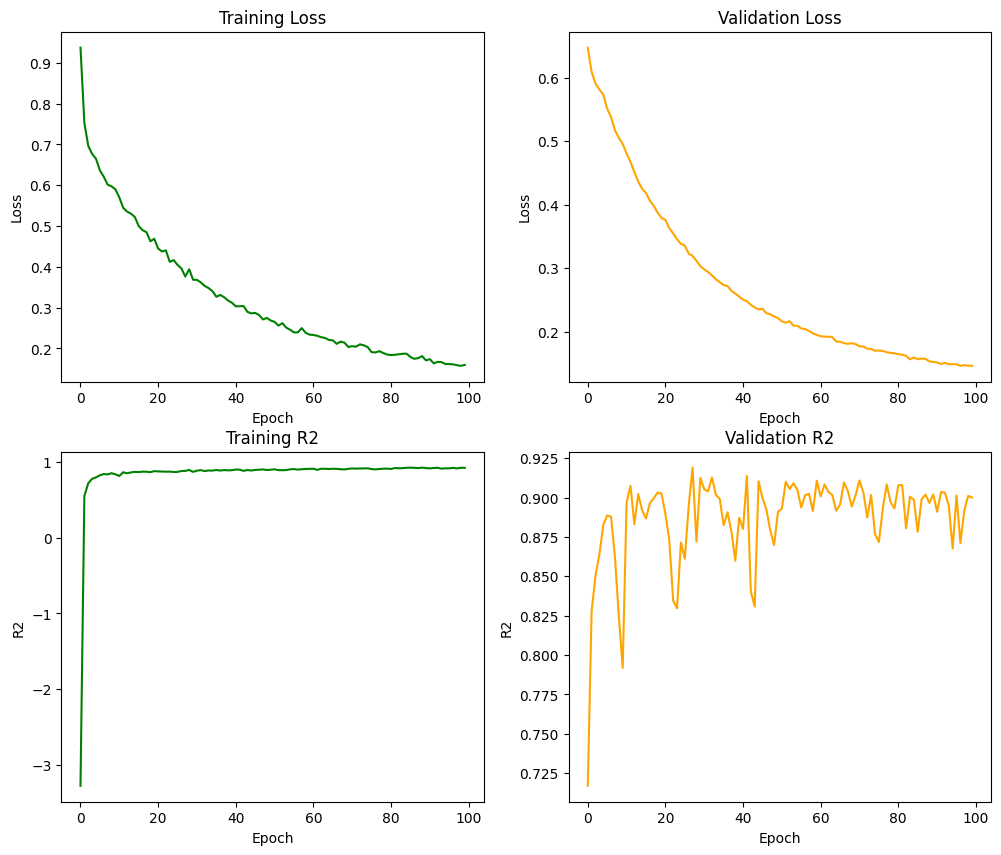

In [107]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_r2, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='R2')
ax[1, 0].set_title('Training R2')

ax[1, 1].plot(val_r2, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='R2')
ax[1, 1].set_title('Validation R2')

plt.show()

In [108]:
model.eval()
with torch.no_grad():
  test_predict = model(X_test.to(device))
  print(f"Test Accuracy: {accuracy_score(y_test.cpu().detach().numpy(), np.argmax(test_predict.cpu().detach().numpy(), axis=1))}")

Test Accuracy: 0.9


In [118]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.ln = nn.Sequential(
        nn.Linear(input_dims, hidden_dims)
    )
  def forward(self, x):
    return self.ln(x).squeeze(1)

input_dims = X_train.shape[1]
hidden_dims = 128
output_dims = y_train.unique().shape[0]

model = MLP(input_dims, hidden_dims, output_dims).to(device)
from sklearn.metrics import accuracy_score
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(epochs):
  model.train()
  train_loss = 0.0
  train_predict = []
  val_predict = []
  train_target = []
  val_target = []
  val_loss = 0.0
  for i, (Xi, yi) in enumerate(train_loader):
    Xi, yi = Xi.to(device), yi.to(device)
    optimizer.zero_grad()
    output = model(Xi)
    loss = criterion(output, yi)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_predict.append(output.cpu().detach().numpy())
    train_target.append(yi.cpu().detach().numpy())
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_acc.append(accuracy_score(np.concatenate(train_target), np.argmax(np.concatenate(train_predict), axis=1)))

  model.eval()
  with torch.no_grad():
    for i, (Xi, yi) in enumerate(val_loader):
      Xi, yi = Xi.to(device), yi.to(device)
      output = model(Xi)
      loss = criterion(output, yi)
      val_loss += loss.item()
      val_predict.append(output.cpu().detach().numpy())
      val_target.append(yi.cpu().detach().numpy())
      val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc.append(accuracy_score(np.concatenate(val_target), np.argmax(np.concatenate(val_predict), axis=1)))
  if epoch % 10 == 0:
    print(f"Epochs: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
model.eval()
with torch.no_grad():
  test_predict = model(X_test.to(device))
  print(f"Test R2: {accuracy_score(y_test.cpu().detach().numpy(), np.argmax(test_predict.cpu().detach().numpy(), axis=1))}")


Epochs: 1/100, Train Loss: 5.1787, Val Loss: 3.8014
Epochs: 11/100, Train Loss: 2.1659, Val Loss: 1.7496
Epochs: 21/100, Train Loss: 1.3014, Val Loss: 1.1772
Epochs: 31/100, Train Loss: 1.0918, Val Loss: 1.0048
Epochs: 41/100, Train Loss: 0.9922, Val Loss: 0.9195
Epochs: 51/100, Train Loss: 0.9346, Val Loss: 0.8647
Epochs: 61/100, Train Loss: 0.8837, Val Loss: 0.8266
Epochs: 71/100, Train Loss: 0.8508, Val Loss: 0.7981
Epochs: 81/100, Train Loss: 0.8392, Val Loss: 0.7748
Epochs: 91/100, Train Loss: 0.8112, Val Loss: 0.7565
Test R2: 0.6


In [119]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.ln = nn.Sequential(
        nn.Linear(input_dims, hidden_dims),
        nn.Sigmoid(),
        nn.Linear(hidden_dims, output_dims)
    )
  def forward(self, x):
    return self.ln(x).squeeze(1)

input_dims = X_train.shape[1]
hidden_dims = 128
output_dims = y_train.unique().shape[0]

model = MLP(input_dims, hidden_dims, output_dims).to(device)
from sklearn.metrics import accuracy_score
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(epochs):
  model.train()
  train_loss = 0.0
  train_predict = []
  val_predict = []
  train_target = []
  val_target = []
  val_loss = 0.0
  for i, (Xi, yi) in enumerate(train_loader):
    Xi, yi = Xi.to(device), yi.to(device)
    optimizer.zero_grad()
    output = model(Xi)
    loss = criterion(output, yi)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_predict.append(output.cpu().detach().numpy())
    train_target.append(yi.cpu().detach().numpy())
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_acc.append(accuracy_score(np.concatenate(train_target), np.argmax(np.concatenate(train_predict), axis=1)))

  model.eval()
  with torch.no_grad():
    for i, (Xi, yi) in enumerate(val_loader):
      Xi, yi = Xi.to(device), yi.to(device)
      output = model(Xi)
      loss = criterion(output, yi)
      val_loss += loss.item()
      val_predict.append(output.cpu().detach().numpy())
      val_target.append(yi.cpu().detach().numpy())
      val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc.append(accuracy_score(np.concatenate(val_target), np.argmax(np.concatenate(val_predict), axis=1)))
  if epoch % 10 == 0:
    print(f"Epochs: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
model.eval()
with torch.no_grad():
  test_predict = model(X_test.to(device))
  print(f"Test Accuracy: {accuracy_score(y_test.cpu().detach().numpy(), np.argmax(test_predict.cpu().detach().numpy(), axis=1))}")


Epochs: 1/100, Train Loss: 1.1048, Val Loss: 0.7679
Epochs: 11/100, Train Loss: 0.7643, Val Loss: 0.6815
Epochs: 21/100, Train Loss: 0.7564, Val Loss: 0.6599
Epochs: 31/100, Train Loss: 0.7436, Val Loss: 0.6550
Epochs: 41/100, Train Loss: 0.7361, Val Loss: 0.6518
Epochs: 51/100, Train Loss: 0.7546, Val Loss: 0.6772
Epochs: 61/100, Train Loss: 0.7430, Val Loss: 0.6574
Epochs: 71/100, Train Loss: 0.7252, Val Loss: 0.6743
Epochs: 81/100, Train Loss: 0.7324, Val Loss: 0.7153
Epochs: 91/100, Train Loss: 0.7161, Val Loss: 0.6634
Test Accuracy: 0.6333333333333333


In [120]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.ln = nn.Sequential(
        nn.Linear(input_dims, hidden_dims),
        nn.Tanh(),
        nn.Linear(hidden_dims, output_dims)
    )
  def forward(self, x):
    return self.ln(x).squeeze(1)

input_dims = X_train.shape[1]
hidden_dims = 128
output_dims = y_train.unique().shape[0]

model = MLP(input_dims, hidden_dims, output_dims).to(device)
from sklearn.metrics import accuracy_score
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(epochs):
  model.train()
  train_loss = 0.0
  train_predict = []
  val_predict = []
  train_target = []
  val_target = []
  val_loss = 0.0
  for i, (Xi, yi) in enumerate(train_loader):
    Xi, yi = Xi.to(device), yi.to(device)
    optimizer.zero_grad()
    output = model(Xi)
    loss = criterion(output, yi)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_predict.append(output.cpu().detach().numpy())
    train_target.append(yi.cpu().detach().numpy())
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_acc.append(accuracy_score(np.concatenate(train_target), np.argmax(np.concatenate(train_predict), axis=1)))

  model.eval()
  with torch.no_grad():
    for i, (Xi, yi) in enumerate(val_loader):
      Xi, yi = Xi.to(device), yi.to(device)
      output = model(Xi)
      loss = criterion(output, yi)
      val_loss += loss.item()
      val_predict.append(output.cpu().detach().numpy())
      val_target.append(yi.cpu().detach().numpy())
      val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc.append(accuracy_score(np.concatenate(val_target), np.argmax(np.concatenate(val_predict), axis=1)))
  if epoch % 10 == 0:
    print(f"Epochs: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
model.eval()
with torch.no_grad():
  test_predict = model(X_test.to(device))
  print(f"Test Accuracy: {accuracy_score(y_test.cpu().detach().numpy(), np.argmax(test_predict.cpu().detach().numpy(), axis=1))}")


Epochs: 1/100, Train Loss: 0.8371, Val Loss: 0.6706
Epochs: 11/100, Train Loss: 0.7100, Val Loss: 0.6492
Epochs: 21/100, Train Loss: 0.6378, Val Loss: 0.5821
Epochs: 31/100, Train Loss: 0.5712, Val Loss: 0.5265
Epochs: 41/100, Train Loss: 0.5065, Val Loss: 0.4640
Epochs: 51/100, Train Loss: 0.4289, Val Loss: 0.3881
Epochs: 61/100, Train Loss: 0.3734, Val Loss: 0.3379
Epochs: 71/100, Train Loss: 0.3240, Val Loss: 0.2823
Epochs: 81/100, Train Loss: 0.2724, Val Loss: 0.2571
Epochs: 91/100, Train Loss: 0.2503, Val Loss: 0.2160
Test Accuracy: 0.9


In [127]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.ln = nn.Sequential(
        nn.Linear(input_dims, hidden_dims),
        nn.Tanh(),
        nn.Linear(hidden_dims, output_dims)
    )
  def forward(self, x):
    return self.ln(x).squeeze(1)

input_dims = X_train.shape[1]
hidden_dims = 512
output_dims = y_train.unique().shape[0]

model = MLP(input_dims, hidden_dims, output_dims).to(device)
from sklearn.metrics import accuracy_score
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(epochs):
  model.train()
  train_loss = 0.0
  train_predict = []
  val_predict = []
  train_target = []
  val_target = []
  val_loss = 0.0
  for i, (Xi, yi) in enumerate(train_loader):
    Xi, yi = Xi.to(device), yi.to(device)
    optimizer.zero_grad()
    output = model(Xi)
    loss = criterion(output, yi)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_predict.append(output.cpu().detach().numpy())
    train_target.append(yi.cpu().detach().numpy())
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_acc.append(accuracy_score(np.concatenate(train_target), np.argmax(np.concatenate(train_predict), axis=1)))

  model.eval()
  with torch.no_grad():
    for i, (Xi, yi) in enumerate(val_loader):
      Xi, yi = Xi.to(device), yi.to(device)
      output = model(Xi)
      loss = criterion(output, yi)
      val_loss += loss.item()
      val_predict.append(output.cpu().detach().numpy())
      val_target.append(yi.cpu().detach().numpy())
      val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc.append(accuracy_score(np.concatenate(val_target), np.argmax(np.concatenate(val_predict), axis=1)))
  if epoch % 10 == 0:
    print(f"Epochs: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
model.eval()
with torch.no_grad():
  test_predict = model(X_test.to(device))
  acc = compute_accuracy(test_predict.cpu(), y_test.cpu())
  print(f"Test Accuracy: {acc}")

Epochs: 1/100, Train Loss: 0.8837, Val Loss: 1.0087
Epochs: 11/100, Train Loss: 0.6988, Val Loss: 0.7433
Epochs: 21/100, Train Loss: 0.5457, Val Loss: 0.6289
Epochs: 31/100, Train Loss: 0.4235, Val Loss: 0.4209
Epochs: 41/100, Train Loss: 0.3724, Val Loss: 0.3187
Epochs: 51/100, Train Loss: 0.3182, Val Loss: 0.2641
Epochs: 61/100, Train Loss: 0.2773, Val Loss: 0.2561
Epochs: 71/100, Train Loss: 0.2556, Val Loss: 0.1881
Epochs: 81/100, Train Loss: 0.2069, Val Loss: 0.1934
Epochs: 91/100, Train Loss: 0.1747, Val Loss: 0.1677
Test Accuracy: 0.9


In [129]:
!gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=c97aba24-fd86-4bdb-b98d-64ed29f60db0
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:00<00:00, 102MB/s]


In [130]:
!unzip -q FER-2013.zip

In [131]:
device = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
  torch.cuda.manual_seed(random_state)

import os
train_dir = 'train'
test_dir = 'test'

classes = os.listdir(train_dir)
cls2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2cls = {idx: cls for cls, idx in cls2idx.items()}

from PIL import Image
import cv2
sample_path = '/content/test/angry/PrivateTest_11296953.jpg'
img = cv2.imread(sample_path)
np.array(img).shape

(48, 48, 3)

In [132]:
os.listdir(train_dir)

['happy', 'angry', 'sad', 'neutral', 'surprise', 'disgust', 'fear']

In [133]:
img_height, img_width = (128, 128)
from torchvision.transforms import Resize
from torchvision.io import read_image

class ImageDataset(Dataset):
  def __init__(self, img_dir, norm, cls2idx, split='train', train_ratio=0.8):
    self.resize = Resize((img_height, img_width))
    self.img_dir = img_dir
    self.norm = norm
    self.cls2idx = cls2idx
    self.split = split
    self.train_ratio = train_ratio
    self.img_paths, self.labels = self.read_files()
    if split in ['train', 'val']:
      train_data, val_data  = train_test_split(
          list(zip(self.img_paths, self.labels)),
          train_size=self.train_ratio,
          stratify=self.labels
      )
      if split == 'train':
        self.img_paths, self.labels = zip(*train_data)
      else:
        self.img_paths, self.labels = zip(*val_data)

  def read_files(self):
    img_paths = []
    labels = []
    for cls in os.listdir(self.img_dir):
      cls_path = os.path.join(self.img_dir, cls)
      for img_name in os.listdir(cls_path):
        img_paths.append(os.path.join(cls_path, img_name))
        labels.append(self.cls2idx[cls])
    return img_paths, labels

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    label = self.labels[idx]
    img = self.resize(read_image(img_path))
    img = img.type(torch.float32)
    if self.norm:
      img = (img /127.5) - 1
    return img, label

In [141]:
train_dataset = ImageDataset(train_dir, norm=True, cls2idx=cls2idx, split='train')
val_dataset = ImageDataset(train_dir, norm=True, cls2idx=cls2idx, split='val')
test_dataset = ImageDataset(test_dir, norm=True, cls2idx=cls2idx, split='test')
train_dataset.__len__()

22967

In [142]:
batchsize = 256
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

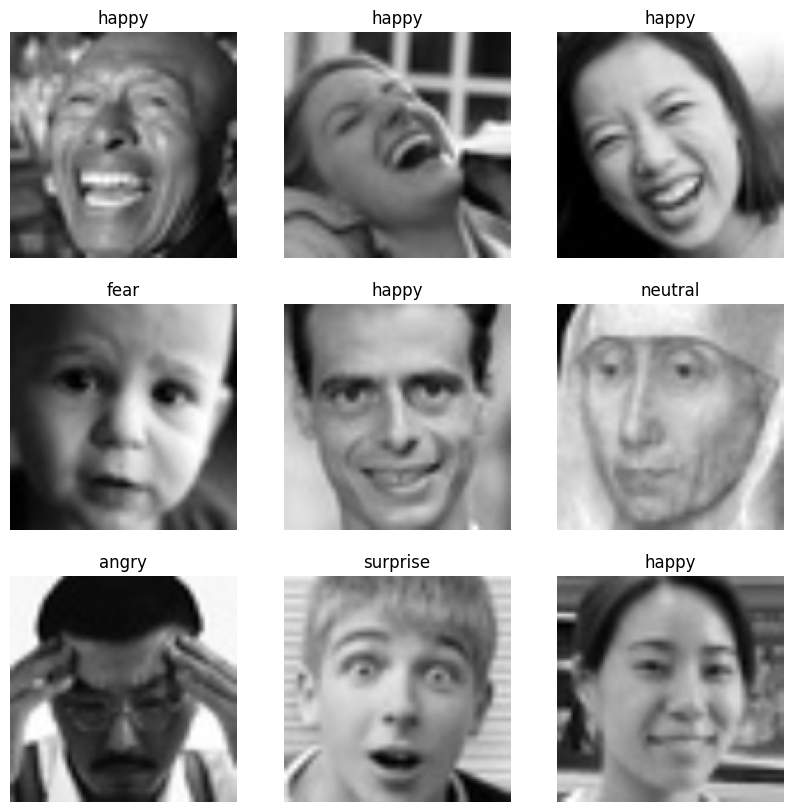

In [143]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2cls[label.item()])
    plt.axis("off")


In [148]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.ln = nn.Sequential(
        nn.Linear(input_dims, hidden_dims * 4),
        nn.ReLU(),
        nn.Linear(hidden_dims * 4, hidden_dims * 2),
        nn.ReLU(),
        # nn.Linear(hidden_dims * 2, hidden_dims),
        # nn.ReLU(),
        nn.Linear(hidden_dims * 2, output_dims)
    )
  def forward(self, x):
    return self.ln(nn.Flatten()(x))

In [149]:
input_dims = img_height * img_width
hidden_dims = 64
output_dims = len(classes)

model = MLP(input_dims, hidden_dims, output_dims).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
epochs = 40
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(epochs):
  model.train()
  train_loss = 0.0
  train_predict = []
  val_predict = []
  train_target = []
  val_target = []
  val_loss = 0
  for i, (Xi, yi) in enumerate(train_loader):
    Xi, yi = Xi.to(device), yi.to(device)
    optimizer.zero_grad()
    output = model(Xi)
    loss = criterion(output, yi)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_predict.append(output.cpu().detach().numpy())
    train_target.append(yi.cpu().detach().numpy())
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_acc.append(accuracy_score(np.concatenate(train_target), np.argmax(np.concatenate(train_predict), axis=1)))
  model.eval()
  with torch.no_grad():
    for i, (Xi, yi) in enumerate(val_loader):
      Xi, yi = Xi.to(device), yi.to(device)
      output = model(Xi)
      loss = criterion(output, yi)
      val_loss += loss.item()
      val_predict.append(output.cpu().detach().numpy())
      val_target.append(yi.cpu().detach().numpy())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc.append(accuracy_score(np.concatenate(val_target), np.argmax(np.concatenate(val_predict), axis=1)))
  if epoch % 10 == 0:
    print(f"Epochs: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epochs: 1/40, Train Loss: 1.8476, Val Loss: 1.7923


In [ ]:
model.eval()
with torch.no_grad():
  test_predict = []
  test_target = []
  for i, (Xi, yi) in enumerate(test_loader):
    Xi, yi = Xi.to(device), yi.to(device)
    output = model(Xi)
    test_predict.append(output.cpu().detach().numpy())
    test_target.append(yi.cpu().detach().numpy())
  print(f"Test Accuracy: {accuracy_score(np.concatenate(test_target), np.argmax(np.concatenate(test_predict), axis=1))}")